# Statistical testing for data analysis: a practical guide


## 1. Categorical vs numerical variables




<p><a name="sections"></a></p>


# Sections

- <a href="#goal">Goal</a>
- <a href="#two-sample">Two-sample Student's T-test</a>
  - <a href="#levene">Levene’s test</a>
- <a href="#welch">Welch's t-test</a>
- <a href="#one">One-way ANOVA</a>
- <a href="#post">Post hoc tests</a>
- <a href="#kruskal">Kruskal-Wallis H test</a>
- <a href="#stat">Statistical Normality Tests</a>

Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install scikit-posthocs
import scikit_posthocs as sp
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as ss

sns.set_theme(style = 'ticks')

<p><a name="goal"></a></p>

## Goal
#### Describe how the characteristics of each patient (e.g., age, sex, and cholesterol levels) affect the metrics of heart function.


Luckily you have access to a Heart Database to do data analysis. Below we describe features included in such database:


- age: Age of the patient

- sex: Sex of the patient

- ex_induced_angina: exercise-induced angina (1 = yes; 0 = no)

- major_vessels: number of major vessels (0-3)

- chestpain: Chest Pain type chest pain type
        Value 1: typical angina
        Value 2: atypical angina
        Value 3: non-anginal pain
        Value 4: asymptomatic
- blood_pressure: resting blood pressure (in mm Hg)

- cholesterol: cholesterol in mg/dl fetched via BMI sensor

- blood_sugar: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

- electrcg_results: resting electrocardiographic results
        Value 0: normal
        Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- max_heart_rate: maximum heart rate achieved
- oldpeak: ST depression induced by exercise relative to rest

- chance_heartattack:   0= less chance of heart attack 1= more chance of heart attack

[Source](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

In [2]:
df = pd.read_csv('https://nycdsaslides.s3.amazonaws.com/LLS/heart.csv',
                 names = ['age','sex','chestpain', 'blood_pressure',\
                          'cholesterol','blood_sugar','electrcg_results',\
                          'max_heart_rate','ex_induced_angina','oldpeak',\
                          'slp','major_vessels','thall','chance_heartattack'], header = 0)

In [3]:
df.head()

,age,sex,chestpain,blood_pressure,cholesterol,blood_sugar,electrcg_results,max_heart_rate,ex_induced_angina,oldpeak,slp,major_vessels,thall,chance_heartattack
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Question 1** : how does age affect the metrics of heart function?

Based on medical evidence, the likelihood of having a heart attack increases after age 45. So let's make a new categorical feature to account for two age groups:

In [4]:
df.loc[df['age'] <= 45, 'age_group'] = 'under45'
df.loc[df['age'] > 45, 'age_group'] = 'over45'

In [5]:
df.head()

,age,sex,chestpain,blood_pressure,cholesterol,blood_sugar,electrcg_results,max_heart_rate,ex_induced_angina,oldpeak,slp,major_vessels,thall,chance_heartattack,age_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,over45
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,under45
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,under45
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,over45
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,over45


- Plot the Maximum heart rate for the different age groups:

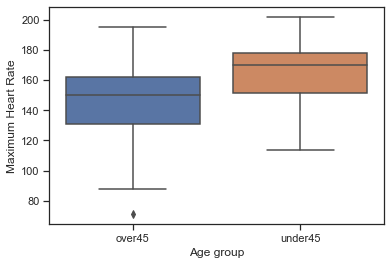

In [6]:
ax = sns.boxplot(x = df["age_group"], y = df['max_heart_rate'])
ax.set(xlabel = 'Age group', ylabel = 'Maximum Heart Rate');

<p><a name="two-sample"></a></p>

From this plot, we can infer that the Maximum Heart rate differs between age groups.
We need to test this hypothesis with statistics!


In this simple case, we would use a 

## Two-sample Student's T-test

-   $H_0:$ No Maximum Heart rate population mean difference between age groups
-   $H_1:$ Maximum Heart rate population means between age groups differ


Before jumping right into the test, we need to check if our data meets this test's [assumptions](https://en.wikipedia.org/wiki/Student%27s_t-test#Assumptions):

1. Independence of the observations. This is a study design issue, you should make sure that the observations do not depend on each other. 

2. Normal distribution. We want to look at the distribution of the numerical variable and make sure that it is close to normal


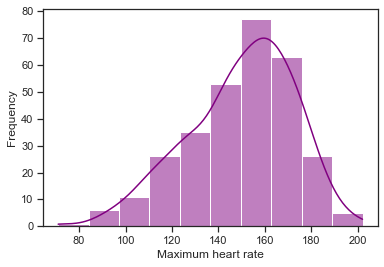

In [7]:
ax = sns.histplot(df['max_heart_rate'],
                  bins = 10,
                  kde = True,
                  color = 'purple')
ax.set(xlabel = 'Maximum heart rate', ylabel = 'Frequency');

# This plot shows that the Max heart rate is sligthtly left-skewed, but still follows a fairly normal distribution

A way for visualizing if the distribution is normal is the quantile-quantile plot (Q-Q plot)

<ipython-input-8-907b7aad1b16>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


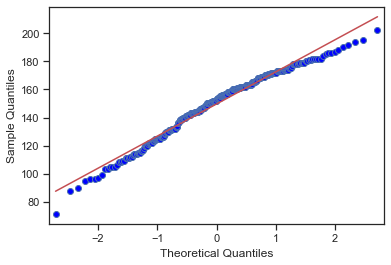

In [8]:
plot = qqplot(df['max_heart_rate'], line = 's') #draw the standardized line with 's' in line argument
plot.show()

3. Equality of variances. We need to test whether the variances for the two categories are equal

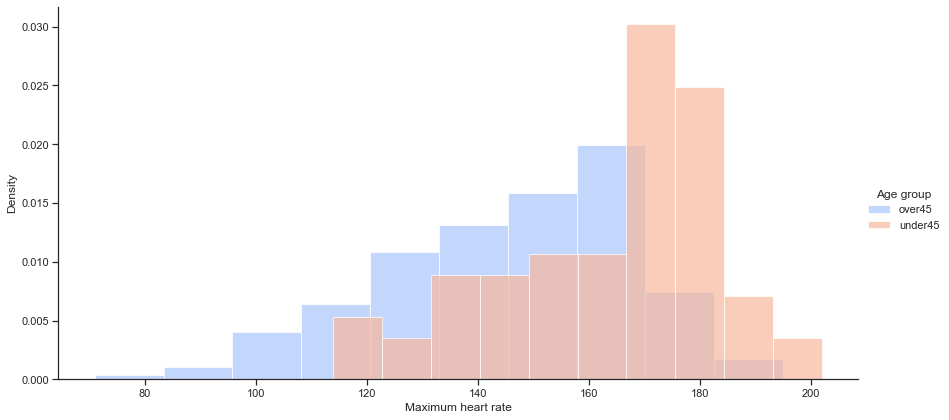

In [9]:
ax = sns.FacetGrid(df, hue='age_group', palette='coolwarm',height = 6, aspect = 2)
ax.map(plt.hist,'max_heart_rate', bins=10, alpha=0.7, density = True)
ax.set(xlabel = 'Maximum heart rate', ylabel = 'Density')
ax.add_legend(title = 'Age group');

<p><a name="levene"></a></p>

### Levene’s test

Test for equality of variances

-   $H_0:$ Variances are equal
-   $H_1:$ At least one of the variances differ


The three variations of Levene’s test are:

‘median’: Recommended for skewed distributions

‘mean’: Recommended for symmetric, moderate-tailed distributions.

‘trimmed’: Recommended for heavy-tailed distributions.

In [10]:
ss.levene(df.loc[df['age_group'] == 'under45', 'max_heart_rate'],
          df.loc[df['age_group'] == 'over45', 'max_heart_rate'], center='mean')

# since the p-value is greater than 0.05 we can assume equality of variance

LeveneResult(statistic=0.8453227915280583, pvalue=0.35861507725806074)

Finally, we can appropriately apply the T-test

In [11]:
ss.ttest_ind(df.loc[df['age_group'] == 'under45', 'max_heart_rate'],
             df.loc[df['age_group'] == 'over45', 'max_heart_rate'], equal_var = True)

Ttest_indResult(statistic=5.93645694333469, pvalue=8.013833907717787e-09)

Since the p-value is so small, we can confidently reject the null hypothesis

-------------------
------------------- 



Let's look at an example that's not so well behaved

**Question 2**: how the sex influences the cholesterol levels in the patient?

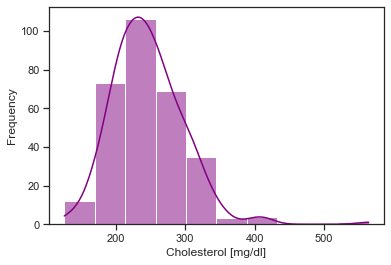

In [12]:
ax = sns.histplot(df['cholesterol'],
                  bins = 10,
                  kde = True,
                  color = 'purple')
ax.set(xlabel = 'Cholesterol [mg/dl]', ylabel = 'Frequency');

<ipython-input-13-77ab26abc60b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


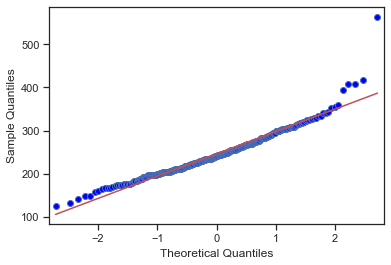

In [13]:
plot = qqplot(df['cholesterol'], line = 's') #draw the standardized line with 's' in line argument
plot.show()

The QQ plot confirms the observation we made that the data is skewed, in particular at the top of the plot. However, this should not be an issue as you'll see below.

- Plot cholesterol concentration for the different sexes:

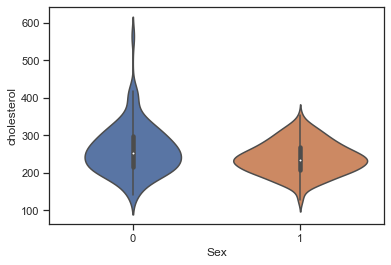

In [14]:
ax = sns.violinplot(x = df['sex'], y = df['cholesterol'])
ax.set(xlabel = 'Sex', ylabel = 'cholesterol');

In [15]:
ss.levene(df.loc[df['sex'] == 0, 'cholesterol'],
          df.loc[df['sex'] == 1, 'cholesterol'], center='median') #median because of skewed distribution

# since the p-value is smaller than 0.05 we can assume that variances are unequal

LeveneResult(statistic=11.375979446083482, pvalue=0.0008413141768722222)

<p><a name="welch"></a></p>

What do you do if the variances are not equal?

## Welch's t-test

Also known as unequal variances T-test

-   $H_0:$ Cholesterol population means are equal between sexes
-   $H_1:$ Cholesterol population means differ between sexes 

Although it follows the normality assumption, Welch's t-test remains robust for skewed distributions and large sample sizes (click [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3445820/) for further reading)

In [16]:
#Set equal_var = False makes this a Welch's t-test

ss.ttest_ind(df.loc[df['sex'] == 0, 'cholesterol'],
             df.loc[df['sex'] == 1, 'cholesterol'], equal_var = False)

Ttest_indResult(statistic=3.02437866568881, pvalue=0.00298541775416255)

Since the p-value is so small, we can confidently reject the null hypothesis

<p><a name="one"></a></p>

**Question 3**: how the electrocardiogram results influence the maximum heart rate in the patients?

There are 3 categories of electrocardiogram results: normal(0), abnormal(1), and hypertrophy(2)


## Comparing more than two categories

**One-way ANOVA** is a standard test useful to determine whether there are statistically significant differences between the means of three or more categories.

Why not make a few t-tests instead? Every time we use a t-test, there's a chance that we are rejecting the null hypothesis when it is true (type I error). Usually, this is a 5% probability. So if we "stack" three t-tests, our type I error probability would go up to 15%, which is unacceptable.  


## One-way ANOVA



- $H_0:$ There is no difference in population means across the categories.

- $H_1:$ At least one of the means is not the same.



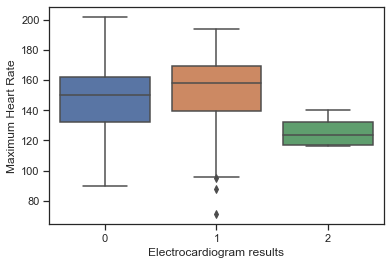

In [17]:
ax = sns.boxplot(x = df["electrcg_results"], y = df['max_heart_rate'])
ax.set(xlabel = 'Electrocardiogram results', ylabel = 'Maximum Heart Rate');

Test for variances equality

In [18]:
normal = df.loc[df['electrcg_results'] == 0, 'max_heart_rate']
abnormal = df.loc[df['electrcg_results'] == 1, 'max_heart_rate']
hypertrophy = df.loc[df['electrcg_results'] == 2, 'max_heart_rate']
        
ss.levene(normal, abnormal, hypertrophy , center='mean')
# since the p-value is greater than 0.05 we can assume equality of variance

LeveneResult(statistic=1.0536615906859164, pvalue=0.3499453938945831)

In [19]:
f_statistic, p_value = ss.f_oneway(normal, abnormal, hypertrophy)

print(f"F_Statistic: {f_statistic:.4f}, P-Value: {p_value:.4f}")



F_Statistic: 3.4319, P-Value: 0.0336


<p><a name="post"></a></p>

Since the p-value is smaller than 0.05 we can reject the null hypothesis and state that there's significant evidence that at least one of the means differ.

But which one? Post hoc (*a posteriori*) tests can confirm where the differences occurred between groups.

## Post hoc tests

When we reject the null hypothesis with a one-way ANOVA, we can run Post hoc tests. Similar to using one-way ANOVA instead of multiple t-tests, post hoc tests attempt to control for the additive experimentwise type I error.

There are more than a docen post hoc tests, to learn more about them you can start [here](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/post-hoc/)

In [20]:
p_values = sp.posthoc_ttest(df, val_col='max_heart_rate', group_col='electrcg_results', p_adjust='holm')
p_values

,0,1,2
0,1.000000,0.125316,0.099689
1,0.125316,1.000000,0.080325
2,0.099689,0.080325,1.000000


In [21]:
def posthoc_vis(p_valuesDF, p_value_threshold):
    # Make a mask to only show the lower left part of the table
    mask = np.triu(np.ones_like(p_valuesDF, dtype=bool))

    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    vis = sns.heatmap(p_valuesDF, mask=mask, cmap = cmap, center = p_value_threshold,
                square=True, linewidths=.5, annot=True);

    return vis

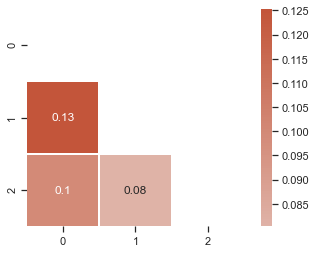

In [22]:
posthoc_vis(p_values, 0.05);

-------------------
------------------- 



Again, let's look at an example that's not so well behaved

**Question 4**: how the kind of chest pain relates to the oldpeak measurement (ST depression induced by exercise) in the patient?

There are 4 kinds of chest pain classifications: typical angina (0), atypical angina(1), non anginal(2), and asymptomatic(3)

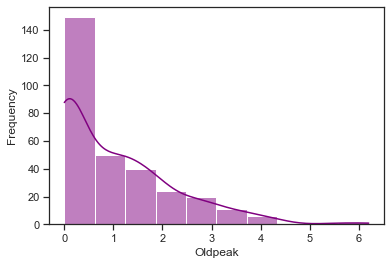

In [23]:
ax = sns.histplot(df['oldpeak'],
                  bins = 10,
                  kde = True,
                  color = 'purple')
ax.set(xlabel = 'Oldpeak', ylabel = 'Frequency');

<ipython-input-24-d272629d90fe>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


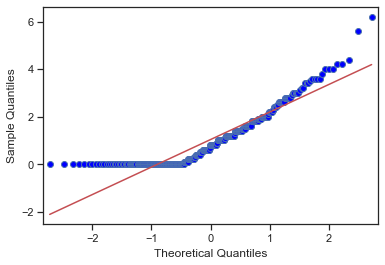

In [24]:
plot = qqplot(df['oldpeak'], line = 's') #draw the standardized line with 's' in line argument
plot.show()

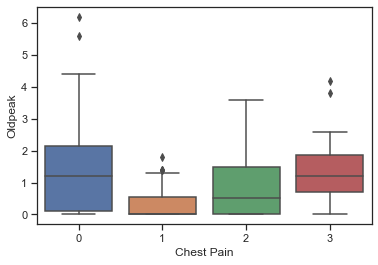

In [25]:
ax = sns.boxplot(x = df["chestpain"], y = df['oldpeak'])
ax.set(xlabel = 'Chest Pain', ylabel = 'Oldpeak');

In [26]:
typical_angina = df.loc[df['chestpain'] == 0, 'oldpeak']
atypical_angina = df.loc[df['chestpain'] == 1, 'oldpeak']
non_anginal = df.loc[df['chestpain'] == 2, 'oldpeak']
asymptomatic = df.loc[df['chestpain'] == 3, 'oldpeak']

ss.levene(typical_angina, atypical_angina, non_anginal, asymptomatic, center = 'trimmed')
# since the p-value is smaller than 0.05 we can reject the null hypothesis and state that at least one 
# variance differs 

LeveneResult(statistic=14.270483707277764, pvalue=1.1628668350496168e-08)

<p><a name="kruskal"></a></p>

If normality and other assumptions are violated use **non-parametric tests**


## Kruskal-Wallis H test

The [Kruskal-Wallis H test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) is the one-way non-parametric ANOVA to test if samples came from the same distribution.

- $H_0:$ Population medians are equal.

- $H_1:$ At least one of the population medians is not equal.

In [27]:
H, p_val = ss.kruskal(typical_angina, atypical_angina, non_anginal, asymptomatic)
p_val

3.1241550922584574e-09

In [28]:
p_valuesKW = sp.posthoc_dunn(df, val_col='oldpeak', group_col='chestpain', p_adjust='holm')
p_valuesKW

,0,1,2,3
0,1.000000e+00,1.204992e-08,0.002148,0.660694
1,1.204992e-08,1.000000e+00,0.011199,0.000085
2,2.147571e-03,1.119932e-02,1.000000,0.030360
3,6.606937e-01,8.458242e-05,0.030360,1.000000


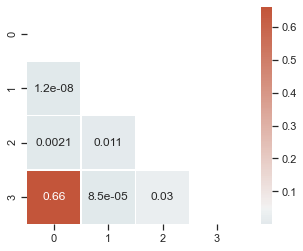

In [29]:
posthoc_vis(p_valuesKW, 0.05);

<p><a name="stat"></a></p>

## Statistical Normality Tests

Formally test whether a sample differs from a normal distribution

-   $H_0:$ the sample comes from a normal distribution
-   $H_1:$ the sample distribution differs from normal


Again, there are many algorithms to test for normality, we will review the following:

1) [Shapiro-Wilk](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro) test: smaller datasets (thousands or less)

2) [D’Agostino and Pearson’s](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest) test: moderate and large sample size


In [30]:
shapiro_test = ss.shapiro(df['oldpeak'])
shapiro_test

ShapiroResult(statistic=0.8441835045814514, pvalue=8.183467206576554e-17)

In [31]:
#This D’Agostino and Pearson’s test combines skew and kurtosis to produce an omnibus test of normality.

dagostino_test = ss.normaltest(df['oldpeak'])
dagostino_test

NormaltestResult(statistic=66.6201580770229, pvalue=3.4167757949760942e-15)